### LABORATORIO 2
Ignacio Méndez Alvarez (22613) y Diego Soto Flores (22737)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

In [2]:
importacion = pd.read_excel("Datos.xlsx", sheet_name= "IMPORTACION", header=6) 
importacion = importacion.iloc[:288].reset_index(drop=True)

consumo = pd.read_excel("Datos.xlsx", sheet_name= "CONSUMO", header=6) 
consumo = consumo.iloc[:300].reset_index(drop= True)

In [3]:
importaciones = importacion[["Fecha", "Gasolina regular", "Gasolina superior", "Diesel alto azufre"]]
consumos = consumo[["Fecha", "Gasolina regular", "Gasolina superior", "Diesel alto azufre"]]

importaciones["Fecha"] = pd.to_datetime(importaciones["Fecha"])
consumos["Fecha"] = pd.to_datetime(consumos["Fecha"])
consumos.dtypes

C:\Users\dfsf2\AppData\Local\Temp\ipykernel_20456\2987316155.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  importaciones["Fecha"] = pd.to_datetime(importaciones["Fecha"])
C:\Users\dfsf2\AppData\Local\Temp\ipykernel_20456\2987316155.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumos["Fecha"] = pd.to_datetime(consumos["Fecha"])


Fecha                 datetime64[ns]
Gasolina regular             float64
Gasolina superior            float64
Diesel alto azufre           float64
dtype: object

In [4]:
consumos.set_index('Fecha', inplace=True)

In [5]:
consumos.head()

,Gasolina regular,Gasolina superior,Diesel alto azufre
Fecha,,,
2000-01-01,202645.20,308156.82,634667.06
2000-02-01,205530.96,307766.31,642380.66
2000-03-01,229499.56,331910.29,699807.25
2000-04-01,210680.40,315648.08,586803.98
2000-05-01,208164.34,319667.97,656948.20


In [6]:
def prediccion_fun(data, modelo, batch_size, scaler, dif=False, dif_cant=1, Series=None, n=1):
    prediccion = [0] * len(data)
    for i, X in enumerate(data):
        # Reformatear a (1, lags, 1)
        X = np.reshape(X, (1, X.shape[0], 1))
        
        # Hacer predicción
        yhat = modelo.predict(X, batch_size=batch_size, verbose=0)
        
        # Invertir el escalado
        yhat = scaler.inverse_transform(yhat)
        
        # Invertir la diferenciación si aplica
        if dif and Series is not None:
            yhat = yhat + Series[n + dif_cant * i]
        
        # Guardar predicción
        prediccion[i] = yhat[0][0]
    
    return prediccion

def supervisada(serie,retrasos):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

### **Modelos consumo**
##### **Gasolina Regular**

In [7]:
regular_c = consumos[["Gasolina regular"]]

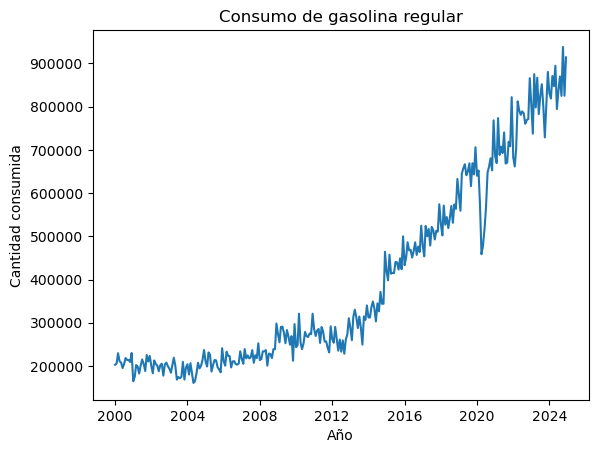

In [8]:
plt.plot(regular_c)
plt.gca().set(title="Consumo de gasolina regular", xlabel="Año", ylabel="Cantidad consumida")
plt.show()

Como se puede observar la serie de tiempo no estacionaria en media, para esto vamos a diferenciar la serie de tiempo para hacer la serie estacionaria en media.

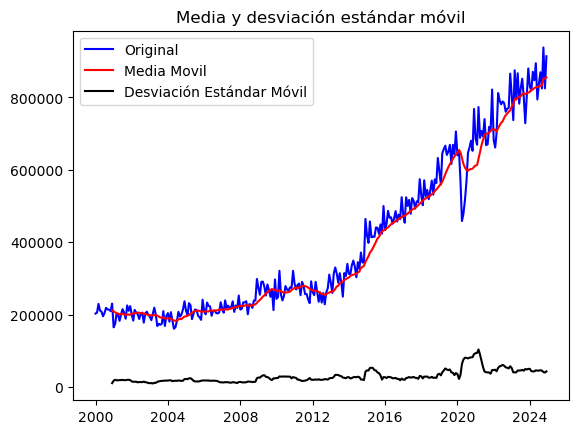

In [9]:
mediaMovil = regular_c.rolling(window=12).mean()
deMovil = regular_c.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(regular_c, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

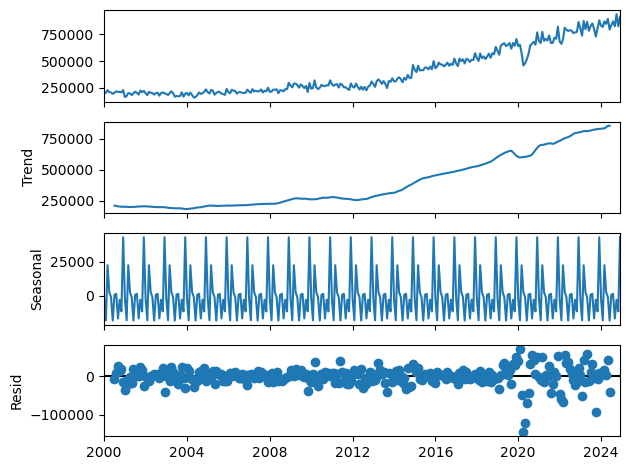

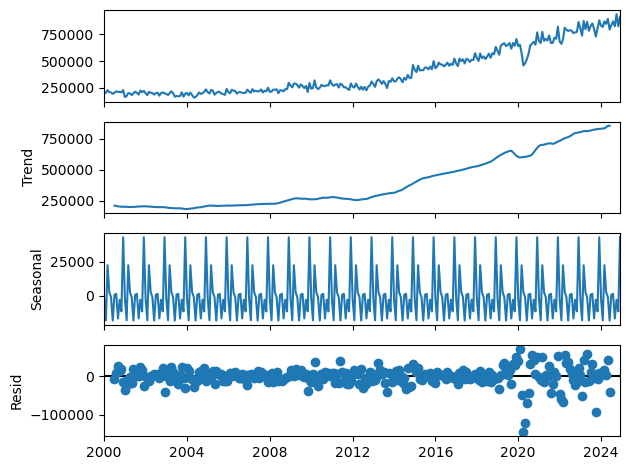

In [10]:
descomposicion = seasonal_decompose(regular_c)
descomposicion.plot()

En este gráfico se puede observar que hay tendencia por lo que la serie no parece ser estacionaria en media y tampoco en varianza.

In [12]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(regular_c, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          2.478789
p-value                        0.999043
# de retardos usados          14.000000
# de observaciones usadas    285.000000
Critical Value (1%)           -3.453505
Critical Value (5%)           -2.871735
Critical Value (10%)          -2.572202
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias, es decir, tiene una tendencia o depende mucho de su valor pasado (no es estacionaria). 

Como la serie no es estacionaria en media, vamos a probar con una diferenciación

In [13]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
regular_c_diff = regular_c.diff()
regular_c_diff.fillna(0,inplace=True)
dfTest = adfuller(regular_c_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.372644
p-value                        0.000332
# de retardos usados          16.000000
# de observaciones usadas    283.000000
Critical Value (1%)           -3.453670
Critical Value (5%)           -2.871808
Critical Value (10%)          -2.572241
dtype: float64


Ya que el valor p es menor a 0.05, se puede indicar que la serie es estacionaria en media.

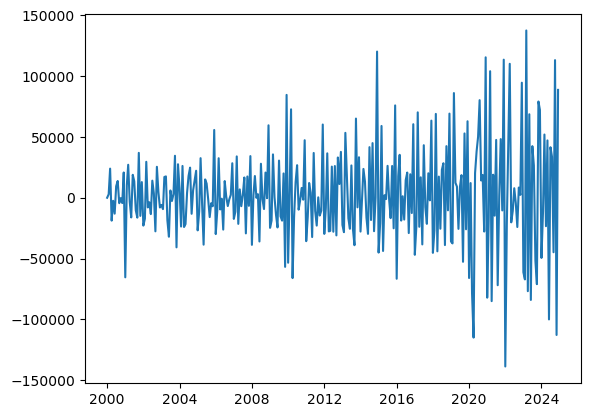

In [14]:
plt.plot(regular_c_diff)

In [15]:
scaler = StandardScaler()
regular_c_scaled = scaler.fit_transform(regular_c_diff) 
regular_c_scaled[1:7]

array([[ 0.01283202],
       [ 0.53837341],
       [-0.52821624],
       [-0.12182156],
       [-0.38504394],
       [ 0.17691121]])

In [16]:
total_len = len(regular_c_scaled)

# Definir proporciones
traincr_prop = 0.6
valcr_prop = 0.2
testcr_prop = 0.2 

# Calcular índices
traincr_end = int(traincr_prop * total_len)
valcr_end = traincr_end + int(valcr_prop * total_len)

# Separar sin solapamientos
traincr= regular_c_scaled[:traincr_end]
validation = regular_c_scaled[traincr_end:valcr_end]
testcr = regular_c_scaled[valcr_end:]

# Si hace falta, redimensionar (por ejemplo para un LSTM univariante)
traincr = traincr.reshape(-1, 1)
validation = validation.reshape(-1, 1)
testcr = testcr.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(traincr)} | Validation: {len(validation)} | Test: {len(testcr)}")

Total registros: 300
Train: 180 | Validation: 60 | Test: 60


In [17]:
traincr, type(traincr)

(array([[-5.91026109e-02],
        [ 1.28320202e-02],
        [ 5.38373409e-01],
        [-5.28216235e-01],
        [-1.21821565e-01],
        [-3.85043944e-01],
        [ 1.76911211e-01],
        [ 2.85687363e-01],
        [-1.70816214e-01],
        [-6.65885727e-02],
        [-1.68264142e-01],
        [ 4.59219291e-01],
        [-1.69118607e+00],
        [ 1.97437219e-01],
        [ 6.17773312e-01],
        [-1.41594016e-01],
        [-4.62411264e-01],
        [ 4.11412684e-01],
        [ 2.79929621e-01],
        [-3.16689643e-01],
        [-4.66776558e-01],
        [ 8.61931679e-01],
        [-4.30920419e-01],
        [ 2.62087551e-01],
        [-6.29943653e-01],
        [-4.87618148e-01],
        [ 6.78559641e-01],
        [-2.57178353e-01],
        [-1.50888215e-01],
        [-3.94478734e-01],
        [ 2.91457568e-01],
        [ 2.93432136e-02],
        [-7.47747530e-01],
        [ 5.76109576e-01],
        [ 5.38827901e-02],
        [-2.58784927e-01],
        [-2.06315433e-01],
 

In [18]:
x_train,y_train = supervisada(traincr,1)
x_val,y_val = supervisada(validation,1)
x_test,y_test = supervisada(testcr,1)

In [19]:
x_train


array([[-5.91026109e-02],
       [ 1.28320202e-02],
       [ 5.38373409e-01],
       [-5.28216235e-01],
       [-1.21821565e-01],
       [-3.85043944e-01],
       [ 1.76911211e-01],
       [ 2.85687363e-01],
       [-1.70816214e-01],
       [-6.65885727e-02],
       [-1.68264142e-01],
       [ 4.59219291e-01],
       [-1.69118607e+00],
       [ 1.97437219e-01],
       [ 6.17773312e-01],
       [-1.41594016e-01],
       [-4.62411264e-01],
       [ 4.11412684e-01],
       [ 2.79929621e-01],
       [-3.16689643e-01],
       [-4.66776558e-01],
       [ 8.61931679e-01],
       [-4.30920419e-01],
       [ 2.62087551e-01],
       [-6.29943653e-01],
       [-4.87618148e-01],
       [ 6.78559641e-01],
       [-2.57178353e-01],
       [-1.50888215e-01],
       [-3.94478734e-01],
       [ 2.91457568e-01],
       [ 2.93432136e-02],
       [-7.47747530e-01],
       [ 5.76109576e-01],
       [ 5.38827901e-02],
       [-2.58784927e-01],
       [-2.06315433e-01],
       [-2.92398842e-01],
       [ 3.6

In [20]:
y_train, type(y_train)

(array([ 1.28320202e-02,  5.38373409e-01, -5.28216235e-01, -1.21821565e-01,
        -3.85043944e-01,  1.76911211e-01,  2.85687363e-01, -1.70816214e-01,
        -6.65885727e-02, -1.68264142e-01,  4.59219291e-01, -1.69118607e+00,
         1.97437219e-01,  6.17773312e-01, -1.41594016e-01, -4.62411264e-01,
         4.11412684e-01,  2.79929621e-01, -3.16689643e-01, -4.66776558e-01,
         8.61931679e-01, -4.30920419e-01,  2.62087551e-01, -6.29943653e-01,
        -4.87618148e-01,  6.78559641e-01, -2.57178353e-01, -1.50888215e-01,
        -3.94478734e-01,  2.91457568e-01,  2.93432136e-02, -7.47747530e-01,
         5.76109576e-01,  5.38827901e-02, -2.58784927e-01, -2.06315433e-01,
        -2.92398842e-01,  3.66876558e-01,  3.78646863e-01, -5.22681656e-01,
        -8.58761668e-01,  9.02090609e-02, -1.25223164e-01,  1.79954917e-02,
         8.02302731e-01, -1.07625340e+00,  6.28196724e-01,  1.37664191e-01,
        -6.49517433e-01,  5.93133527e-01, -6.59248361e-01, -5.98483220e-01,
         4.1

In [21]:
(x_train.shape[0],1,1)

(179, 1, 1)

In [22]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

59

In [23]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1cr = Sequential()
modelo1cr.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

# modelo1.add(LSTM(
#     units=unidades, 
#     batch_input_shape=(lote, paso, caracteristicas), 
#     stateful=True  # activamos estado entre batches
# ))
modelo1cr.add(Dense(1))
modelo1cr.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
modelo1cr.compile(loss='mean_squared_error',optimizer="rmsprop")

In [25]:
epocas = 50
history= modelo1cr.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
179/179 [==============================] - 2s 3ms/step - loss: 0.4405 - val_loss: 0.7921
Epoch 2/50
179/179 [==============================] - 0s 1ms/step - loss: 0.4176 - val_loss: 0.7379
Epoch 3/50
179/179 [==============================] - 0s 1ms/step - loss: 0.4032 - val_loss: 0.6997
Epoch 4/50
179/179 [==============================] - 0s 1ms/step - loss: 0.3941 - val_loss: 0.6726
Epoch 5/50
179/179 [==============================] - 0s 1ms/step - loss: 0.3887 - val_loss: 0.6543
Epoch 6/50
179/179 [==============================] - 0s 1ms/step - loss: 0.3856 - val_loss: 0.6423
Epoch 7/50
179/179 [==============================] - 0s 1ms/step - loss: 0.3839 - val_loss: 0.6346
Epoch 8/50
179/179 [==============================] - 0s 1ms/step - loss: 0.3830 - val_loss: 0.6297
Epoch 9/50
179/179 [==============================] - 0s 1ms/step - loss: 0.3823 - val_loss: 0.6265
Epoch 10/50
179/179 [==============================] - 0s 1ms/step - loss: 0.3819 - val_loss: 0.6244

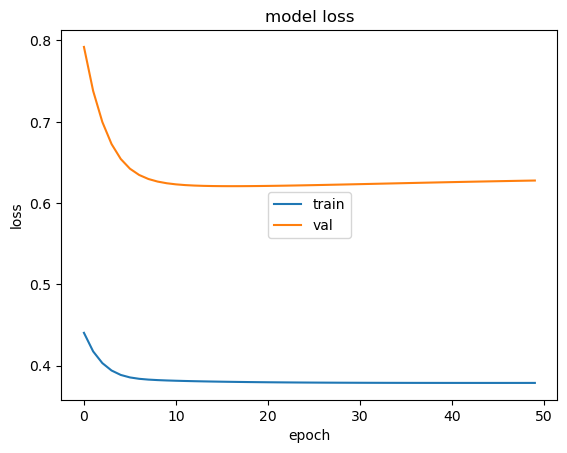

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [27]:
print("Pérdida en Train")
modelo1cr.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1cr.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1cr.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 [==============================] - 0s 1ms/step - loss: 0.3768
Pérdida en Validación
2/2 [==============================] - 0s 3ms/step - loss: 0.6278
Pérdida en Test
2/2 [==============================] - 0s 3ms/step - loss: 2.2106


2.2105603218078613

In [28]:
prediccion_val = []

prediccion_val = prediccion_fun(x_val,modelo1cr, 1,scaler,dif=True,dif_cant=1, Series = regular_c.values , n=traincr_end)
prediccion_test = prediccion_fun(x_test,modelo1cr, 1,scaler,dif=True,dif_cant=1, Series = regular_c.values , n = len(regular_c.values) - len(x_test))

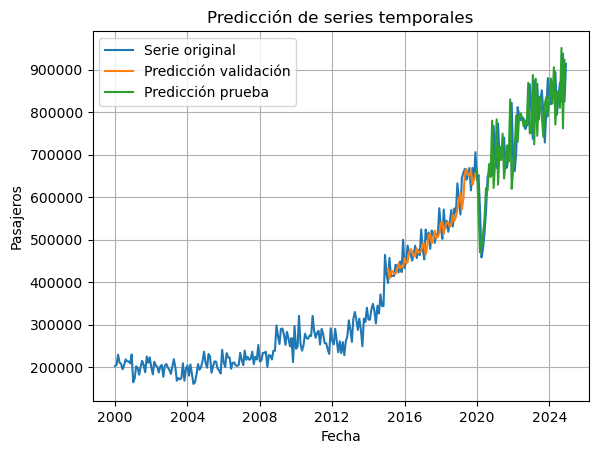

In [29]:
df_val = pd.DataFrame(prediccion_val, index=regular_c[traincr_end+1:valcr_end].index)
df_test = pd.DataFrame(prediccion_test, index=regular_c[valcr_end:].index[:len(prediccion_test)])


plt.plot(regular_c, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()


In [30]:

# Valores reales y predichos
y_true = regular_c[valcr_end:].iloc[:len(prediccion_test)]
y_pred = prediccion_test  

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

if isinstance(y_true, pd.DataFrame):
    promedio = y_true.iloc[:, 0].mean() 
else:
    promedio = y_true.mean()

# Calcular error relativo
error_relativo = (rmse / promedio) * 100

# Mostrar resultados
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Error relativo: {error_relativo:.2f}%")


MSE: 6738219397.21
RMSE: 82086.66
Error relativo: 10.98%


#### Tuneo de Modelo 1 (Consumo Regular)

In [31]:
x_train,y_train = supervisada(traincr,3)
x_val,y_val = supervisada(validation,3)
x_test,y_test = supervisada(testcr,3)

In [32]:
unidades =  10
paso = 3 # lags, 3 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo2cr = Sequential()
modelo2cr.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

# modelo1.add(LSTM(
#     units=unidades, 
#     batch_input_shape=(lote, paso, caracteristicas), 
#     stateful=True  # activamos estado entre batches
# ))
modelo2cr.add(Dense(1))
modelo2cr.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                480       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
modelo2cr.compile(loss='mean_squared_error',optimizer="rmsprop")

In [34]:
epocas = 50
history= modelo2cr.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
177/177 [==============================] - 2s 3ms/step - loss: 0.4535 - val_loss: 0.8082
Epoch 2/50
177/177 [==============================] - 0s 1ms/step - loss: 0.4159 - val_loss: 0.7273
Epoch 3/50
177/177 [==============================] - 0s 1ms/step - loss: 0.3856 - val_loss: 0.6583
Epoch 4/50
177/177 [==============================] - 0s 1ms/step - loss: 0.3627 - val_loss: 0.6035
Epoch 5/50
177/177 [==============================] - 0s 1ms/step - loss: 0.3476 - val_loss: 0.5647
Epoch 6/50
177/177 [==============================] - 0s 1ms/step - loss: 0.3388 - val_loss: 0.5394
Epoch 7/50
177/177 [==============================] - 0s 1ms/step - loss: 0.3342 - val_loss: 0.5235
Epoch 8/50
177/177 [==============================] - 0s 1ms/step - loss: 0.3318 - val_loss: 0.5135
Epoch 9/50
177/177 [==============================] - 0s 1ms/step - loss: 0.3303 - val_loss: 0.5071
Epoch 10/50
177/177 [==============================] - 0s 1ms/step - loss: 0.3294 - val_loss: 0.5029

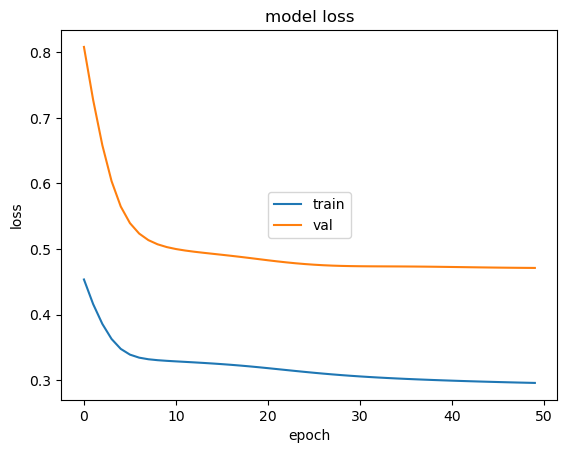

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [36]:
print("Pérdida en Train")
modelo2cr.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2cr.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo2cr.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 [==============================] - 0s 1ms/step - loss: 0.2904
Pérdida en Validación
2/2 [==============================] - 0s 3ms/step - loss: 0.4711
Pérdida en Test
2/2 [==============================] - 0s 2ms/step - loss: 2.2802


2.2801969051361084

In [37]:
prediccion_val = []

prediccion_val = prediccion_fun(x_val,modelo2cr, 1,scaler,dif=True,dif_cant=1, Series = regular_c.values , n=traincr_end)
prediccion_test = prediccion_fun(x_test,modelo2cr, 1,scaler,dif=True,dif_cant=1, Series = regular_c.values , n = len(regular_c.values) - len(x_test))

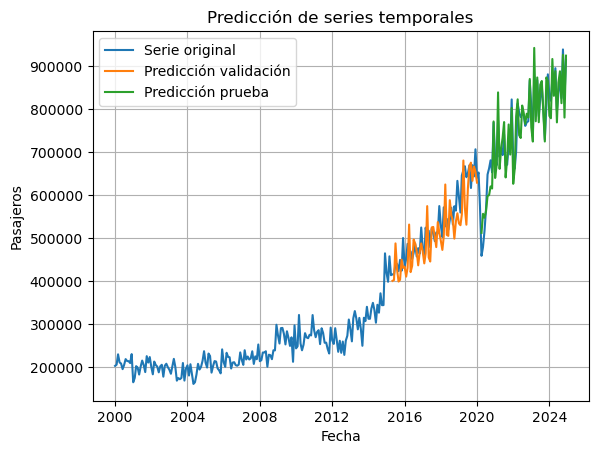

In [38]:
lags = 3  # o el valor que estés usando realmente

# Obtener solo los índices que correspondan exactamente a la cantidad de predicciones
index_val = regular_c.index[traincr_end+1+lags : traincr_end+1+lags + len(prediccion_val)]
index_test = regular_c.index[valcr_end+lags : valcr_end+lags + len(prediccion_test)]

df_val = pd.DataFrame(prediccion_val, index=index_val, columns=['Predicción validación'])
df_test = pd.DataFrame(prediccion_test, index=index_test, columns=['Predicción prueba'])




plt.plot(regular_c, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

In [39]:
# Valores reales y predichos
y_true = regular_c[valcr_end:].iloc[:len(prediccion_test)]
y_pred = prediccion_test  # o df_test.values.flatten()

# Calcular MSE y RMSE
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Calcular promedio correctamente, ya sea Serie o DataFrame
if isinstance(y_true, pd.DataFrame):
    promedio = y_true.iloc[:, 0].mean()  # toma la primera columna
else:
    promedio = y_true.mean()

# Calcular error relativo
error_relativo = (rmse / promedio) * 100

# Mostrar resultados
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Error relativo: {error_relativo:.2f}%")

MSE: 4712945864.42
RMSE: 68650.90
Error relativo: 9.24%


#### Predicción 2025

Input shape: (1, 3, 1)
Input dtype: float32


c:\Users\dfsf2\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\dfsf2\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\dfsf2\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\dfsf2\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\dfsf2\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


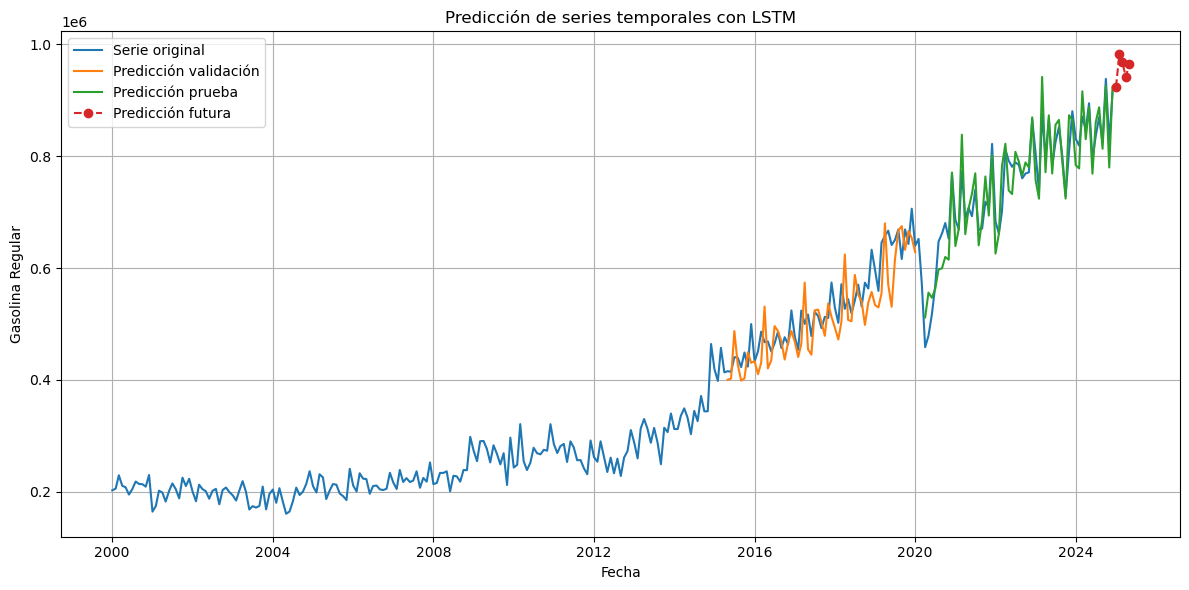

               Predicción
2025-01-01  923632.939180
2025-02-01  982041.657930
2025-03-01  967424.342500
2025-04-01  941369.633516
2025-05-01  964616.801484


In [ ]:
futuro_meses = 5

ultimo_input = x_test[-1:].copy().reshape(1, 3, 1).astype(np.float32)


predicciones_futuras = []
series_aux = list(regular_c.values.flatten())

print("Input shape:", ultimo_input.shape)
print("Input dtype:", ultimo_input.dtype)


yhat_scaled = modelo2cr.predict(ultimo_input, verbose=0)

for i in range(futuro_meses):
    yhat_scaled = modelo2cr.predict(ultimo_input, batch_size=1, verbose=0)
    yhat = scaler.inverse_transform(yhat_scaled)  
    
    yhat_val = yhat[0, 0] + series_aux[-1]  
    predicciones_futuras.append(yhat_val)
    series_aux.append(yhat_val)

    nueva_diff = yhat_val - series_aux[-2]
    nuevo_valor_scaled = scaler.transform([[nueva_diff]])[0, 0]

    
    nuevo_valor_scaled = np.array([[[nuevo_valor_scaled]]], dtype=np.float32)
    ultimo_input = np.concatenate([ultimo_input[:, 1:, :], nuevo_valor_scaled], axis=1)

fechas_futuras = pd.date_range(start=regular_c.index[-1] + pd.offsets.MonthBegin(),
                               periods=futuro_meses, freq='MS')
df_future = pd.DataFrame(predicciones_futuras, index=fechas_futuras, columns=['Predicción'])

plt.figure(figsize=(12, 6))

plt.plot(regular_c, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')
plt.plot(df_future, label='Predicción futura', linestyle='--', marker='o')

plt.legend()
plt.title('Predicción de series temporales con LSTM')
plt.xlabel('Fecha')
plt.ylabel('Gasolina Regular')
plt.grid(True)
plt.tight_layout()
plt.show()

print(df_future)



### **Modelos importacion**
##### **Gasolina Regular**

In [51]:
importaciones.set_index('Fecha', inplace=True)

In [52]:
importaciones.head()

,Gasolina regular,Gasolina superior,Diesel alto azufre
Fecha,,,
2001-01-01,177776.50,373963.96,566101.99
2001-02-01,123115.99,243091.07,489525.80
2001-03-01,161726.42,312084.38,575559.68
2001-04-01,127338.74,285054.89,437745.42
2001-05-01,168730.19,300913.67,552609.13


In [53]:
regular_i = importaciones[["Gasolina regular"]]
regular_i

,Gasolina regular
Fecha,
2001-01-01,177776.50
2001-02-01,123115.99
2001-03-01,161726.42
2001-04-01,127338.74
2001-05-01,168730.19
...,...
2024-08-01,827107.06
2024-09-01,1141365.94
2024-10-01,790347.12


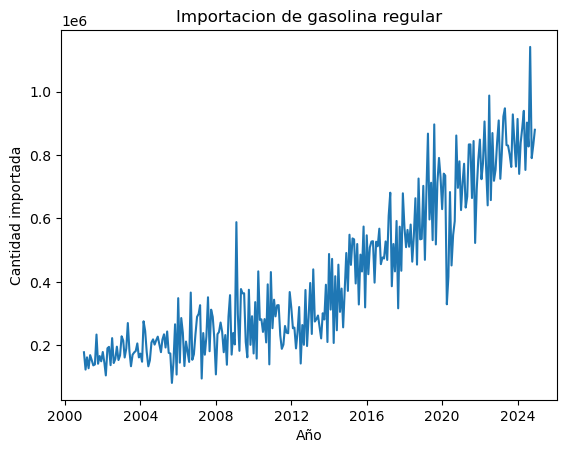

In [54]:
plt.plot(regular_i)
plt.gca().set(title="Importacion de gasolina regular", xlabel="Año", ylabel="Cantidad importada")
plt.show()

Como se puede observar la serie de tiempo no estacionaria en media, para esto vamos a diferenciar la serie de tiempo para hacer la serie estacionaria en media.

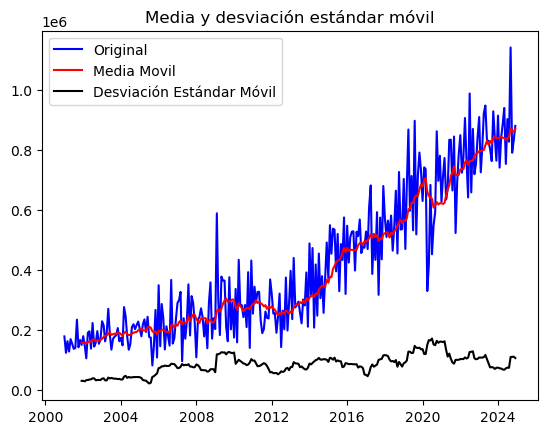

In [55]:
mediaMovil = regular_i.rolling(window=12).mean()
deMovil = regular_i.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(regular_i, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

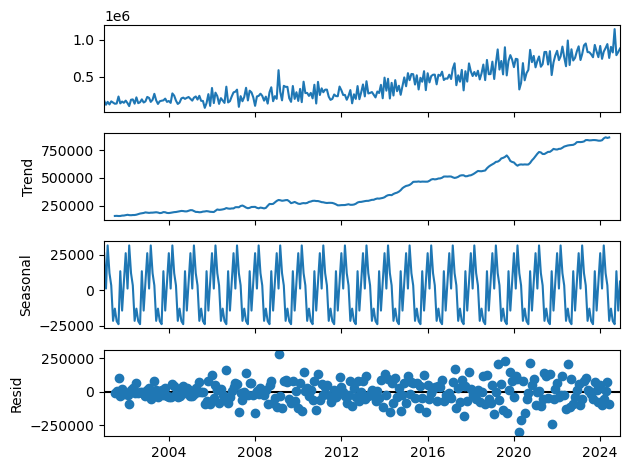

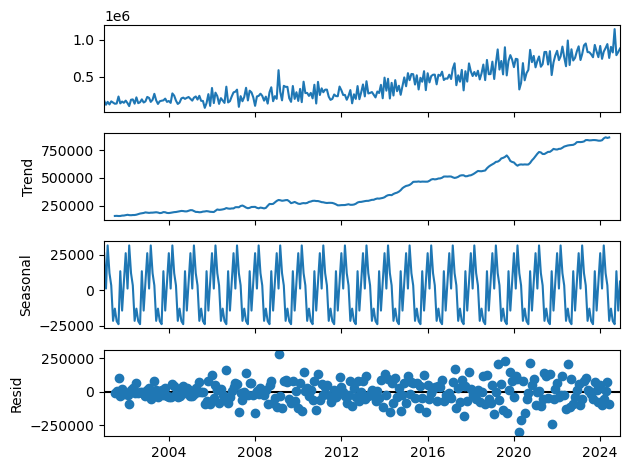

In [56]:
descomposicion = seasonal_decompose(regular_i)
descomposicion.plot()

En este gráfico se puede observar que hay tendencia por lo que la serie no parece ser estacionaria en media y tampoco en varianza.

In [57]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(regular_i, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.830167
p-value                        0.992108
# de retardos usados           9.000000
# de observaciones usadas    278.000000
Critical Value (1%)           -3.454094
Critical Value (5%)           -2.871993
Critical Value (10%)          -2.572340
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias, es decir, tiene una tendencia o depende mucho de su valor pasado (no es estacionaria). 

Como la serie no es estacionaria en media, vamos a probar con una diferenciación

In [58]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
regular_i_diff = regular_i.diff()
regular_i_diff.fillna(0,inplace=True)
dfTest = adfuller(regular_i_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -1.023316e+01
p-value                      4.967668e-18
# de retardos usados         8.000000e+00
# de observaciones usadas    2.790000e+02
Critical Value (1%)         -3.454008e+00
Critical Value (5%)         -2.871956e+00
Critical Value (10%)        -2.572320e+00
dtype: float64


Ya que el valor p es menor a 0.05, se puede indicar que la serie es estacionaria en media.

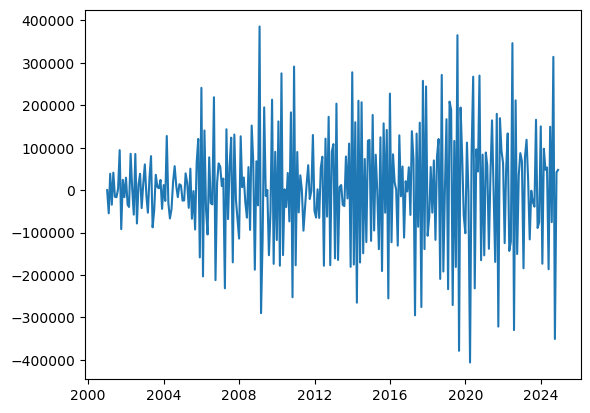

In [59]:
plt.plot(regular_i_diff)

In [60]:
scaler = StandardScaler()
regular_i_scaled = scaler.fit_transform(regular_i_diff) 
regular_i_scaled[1:7]

array([[-0.41838396],
       [ 0.26504895],
       [-0.26983695],
       [ 0.28542658],
       [-0.13386558],
       [-0.13949932]])

In [61]:
total_len = len(regular_i_scaled)

# Definir proporciones
trainir_prop = 0.6
valir_prop = 0.2
testir_prop = 0.2 

# Calcular índices
trainir_end = int(trainir_prop * total_len)
valir_end = trainir_end + int(valir_prop * total_len)

# Separar sin solapamientos
trainir= regular_i_scaled[:trainir_end]
validation = regular_i_scaled[trainir_end:valir_end]
testir = regular_i_scaled[valir_end:]

# Si hace falta, redimensionar (por ejemplo para un LSTM univariante)
trainir = trainir.reshape(-1, 1)
validation = validation.reshape(-1, 1)
testir = testir.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(trainir)} | Validation: {len(validation)} | Test: {len(testir)}")

Total registros: 288
Train: 172 | Validation: 57 | Test: 59


In [62]:
trainir, type(trainir)

(array([[-0.01786488],
        [-0.41838396],
        [ 0.26504895],
        [-0.26983695],
        [ 0.28542658],
        [-0.13386558],
        [-0.13949932],
        [ 0.00460047],
        [ 0.67295214],
        [-0.69267044],
        [ 0.1601266 ],
        [-0.13967393],
        [ 0.19732793],
        [-0.26801243],
        [-0.30930178],
        [ 0.60983895],
        [ 0.01504318],
        [-0.44123656],
        [ 0.60758094],
        [-0.59389328],
        [ 0.07857755],
        [ 0.26401923],
        [-0.32738205],
        [ 0.08773027],
        [ 0.42670855],
        [-0.11882757],
        [-0.40792564],
        [ 0.19145981],
        [ 0.56947678],
        [-0.66067977],
        [-0.37387385],
        [ 0.24764807],
        [ 0.03572526],
        [ 0.01474566],
        [ 0.15767056],
        [-0.34134257],
        [ 0.06969381],
        [-0.20462549],
        [ 0.91711167],
        [-0.24049338],
        [-0.50710426],
        [-0.34794052],
        [ 0.11941201],
        [ 0

In [63]:
x_train,y_train = supervisada(trainir,1)
x_val,y_val = supervisada(validation,1)
x_test,y_test = supervisada(testir,1)

In [64]:
x_train

array([[-0.01786488],
       [-0.41838396],
       [ 0.26504895],
       [-0.26983695],
       [ 0.28542658],
       [-0.13386558],
       [-0.13949932],
       [ 0.00460047],
       [ 0.67295214],
       [-0.69267044],
       [ 0.1601266 ],
       [-0.13967393],
       [ 0.19732793],
       [-0.26801243],
       [-0.30930178],
       [ 0.60983895],
       [ 0.01504318],
       [-0.44123656],
       [ 0.60758094],
       [-0.59389328],
       [ 0.07857755],
       [ 0.26401923],
       [-0.32738205],
       [ 0.08773027],
       [ 0.42670855],
       [-0.11882757],
       [-0.40792564],
       [ 0.19145981],
       [ 0.56947678],
       [-0.66067977],
       [-0.37387385],
       [ 0.24764807],
       [ 0.03572526],
       [ 0.01474566],
       [ 0.15767056],
       [-0.34134257],
       [ 0.06969381],
       [-0.20462549],
       [ 0.91711167],
       [-0.24049338],
       [-0.50710426],
       [-0.34794052],
       [ 0.11941201],
       [ 0.39625817],
       [ 0.05472314],
       [-0

In [65]:
y_train, type(y_train)

(array([-0.41838396,  0.26504895, -0.26983695,  0.28542658, -0.13386558,
        -0.13949932,  0.00460047,  0.67295214, -0.69267044,  0.1601266 ,
        -0.13967393,  0.19732793, -0.26801243, -0.30930178,  0.60983895,
         0.01504318, -0.44123656,  0.60758094, -0.59389328,  0.07857755,
         0.26401923, -0.32738205,  0.08773027,  0.42670855, -0.11882757,
        -0.40792564,  0.19145981,  0.56947678, -0.66067977, -0.37387385,
         0.24764807,  0.03572526,  0.01474566,  0.15767056, -0.34134257,
         0.06969381, -0.20462549,  0.91711167, -0.24049338, -0.50710426,
        -0.34794052,  0.11941201,  0.39625817,  0.05472314, -0.13943784,
         0.08421048,  0.06461512, -0.19900084, -0.19569787,  0.27202858,
         0.10541369, -0.32383948,  0.35296925, -0.51171202, -0.0335156 ,
        -0.69781097,  0.45336238,  0.86649821, -1.18031465,  1.74898848,
        -1.50866454,  1.01335625, -0.36194932, -0.78440047,  0.54891226,
        -0.24223378, -0.26477379,  1.58645539, -1.5

In [66]:
(x_train.shape[0],1,1)

(171, 1, 1)

In [67]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

56

In [68]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1ir = Sequential()
modelo1ir.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

# modelo1.add(LSTM(
#     units=unidades, 
#     batch_input_shape=(lote, paso, caracteristicas), 
#     stateful=True  # activamos estado entre batches
# ))
modelo1ir.add(Dense(1))
modelo1ir.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                480       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
modelo1ir.compile(loss='mean_squared_error',optimizer="rmsprop")

In [70]:
epocas = 50
history= modelo1ir.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
171/171 [==============================] - 2s 3ms/step - loss: 0.6842 - val_loss: 1.3052
Epoch 2/50
171/171 [==============================] - 0s 1ms/step - loss: 0.5919 - val_loss: 1.1236
Epoch 3/50
171/171 [==============================] - 0s 1ms/step - loss: 0.5221 - val_loss: 0.9855
Epoch 4/50
171/171 [==============================] - 0s 1ms/step - loss: 0.4720 - val_loss: 0.8859
Epoch 5/50
171/171 [==============================] - 0s 1ms/step - loss: 0.4387 - val_loss: 0.8182
Epoch 6/50
171/171 [==============================] - 0s 1ms/step - loss: 0.4183 - val_loss: 0.7755
Epoch 7/50
171/171 [==============================] - 0s 1ms/step - loss: 0.4069 - val_loss: 0.7501
Epoch 8/50
171/171 [==============================] - 0s 1ms/step - loss: 0.4008 - val_loss: 0.7355
Epoch 9/50
171/171 [==============================] - 0s 1ms/step - loss: 0.3976 - val_loss: 0.7271
Epoch 10/50
171/171 [==============================] - 0s 1ms/step - loss: 0.3958 - val_loss: 0.7224

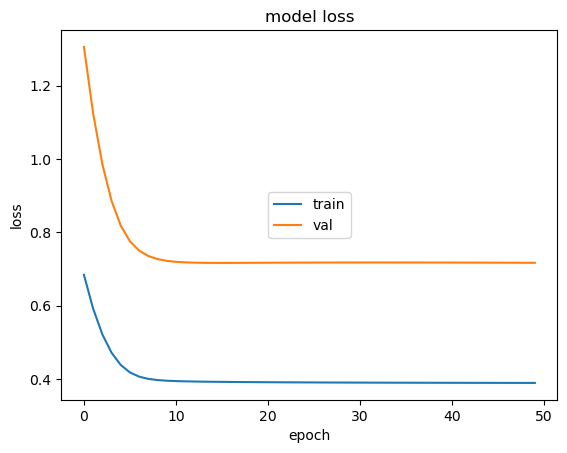

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [72]:
print("Pérdida en Train")
modelo1ir.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1ir.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1ir.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 [==============================] - 0s 1ms/step - loss: 0.3863
Pérdida en Validación
2/2 [==============================] - 0s 2ms/step - loss: 0.7171
Pérdida en Test
2/2 [==============================] - 0s 2ms/step - loss: 1.0307


1.0306823253631592

In [73]:
prediccion_val = []

prediccion_val = prediccion_fun(x_val,modelo1ir, 1,scaler,dif=True,dif_cant=1, Series = regular_i.values , n=trainir_end)
prediccion_test = prediccion_fun(x_test,modelo1ir, 1,scaler,dif=True,dif_cant=1, Series = regular_i.values , n = len(regular_i.values) - len(x_test))

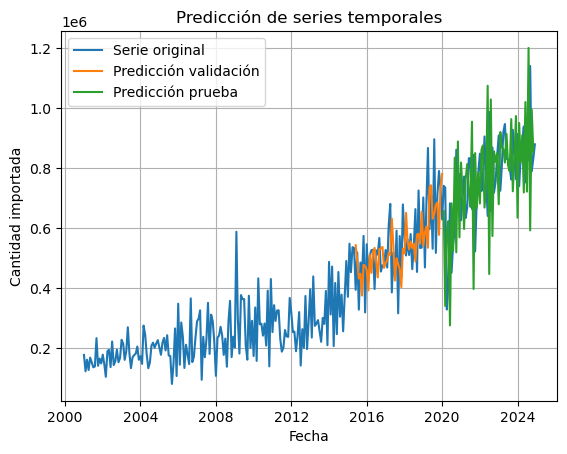

In [74]:
df_val = pd.DataFrame(prediccion_val, index=regular_i[trainir_end+1:valir_end].index)
df_test = pd.DataFrame(prediccion_test, index=regular_i[valir_end:].index[:len(prediccion_test)])


plt.plot(regular_i, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Cantidad importada')
plt.grid(True)
plt.show()


In [75]:

# Valores reales y predichos
y_true = regular_i[valir_end:].iloc[:len(prediccion_test)]
y_pred = prediccion_test  

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

if isinstance(y_true, pd.DataFrame):
    promedio = y_true.iloc[:, 0].mean() 
else:
    promedio = y_true.mean()

# Calcular error relativo
error_relativo = (rmse / promedio) * 100

# Mostrar resultados
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Error relativo: {error_relativo:.2f}%")


MSE: 54156949244.84
RMSE: 232716.46
Error relativo: 30.30%


Tuneo Modelo 1 Importacion Regular

In [76]:
x_train,y_train = supervisada(trainir,6)
x_val,y_val = supervisada(validation,6)
x_test,y_test = supervisada(testir,6)

In [77]:
unidades =  10
paso = 6 # lags, 3 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo2ir = Sequential()
modelo2ir.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

# modelo1.add(LSTM(
#     units=unidades, 
#     batch_input_shape=(lote, paso, caracteristicas), 
#     stateful=True  # activamos estado entre batches
# ))
modelo2ir.add(Dense(1))
modelo2ir.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10)                480       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
modelo2ir.compile(loss='mean_squared_error',optimizer="rmsprop")

In [79]:
epocas = 50
history= modelo2ir.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
166/166 [==============================] - 2s 4ms/step - loss: 0.7091 - val_loss: 1.3836
Epoch 2/50
166/166 [==============================] - 0s 2ms/step - loss: 0.6361 - val_loss: 1.2270
Epoch 3/50
166/166 [==============================] - 0s 2ms/step - loss: 0.5646 - val_loss: 1.0683
Epoch 4/50
166/166 [==============================] - 0s 1ms/step - loss: 0.4961 - val_loss: 0.9178
Epoch 5/50
166/166 [==============================] - 0s 1ms/step - loss: 0.4386 - val_loss: 0.7931
Epoch 6/50
166/166 [==============================] - 0s 1ms/step - loss: 0.3988 - val_loss: 0.7054
Epoch 7/50
166/166 [==============================] - 0s 1ms/step - loss: 0.3763 - val_loss: 0.6511
Epoch 8/50
166/166 [==============================] - 0s 2ms/step - loss: 0.3654 - val_loss: 0.6192
Epoch 9/50
166/166 [==============================] - 0s 2ms/step - loss: 0.3605 - val_loss: 0.6001
Epoch 10/50
166/166 [==============================] - 0s 2ms/step - loss: 0.3582 - val_loss: 0.5878

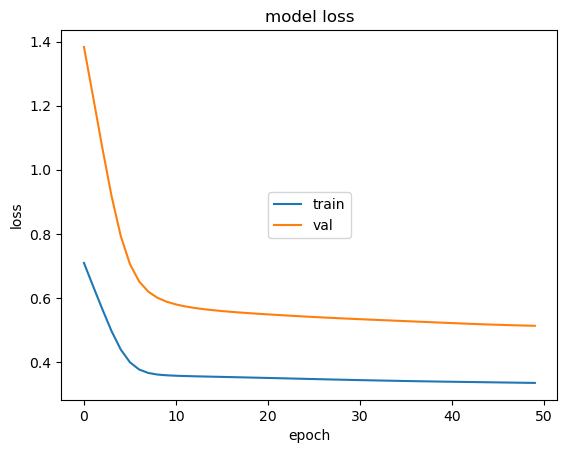

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [81]:
print("Pérdida en Train")
modelo2ir.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2ir.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo2ir.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 [==============================] - 0s 1ms/step - loss: 0.3240
Pérdida en Validación
2/2 [==============================] - 0s 2ms/step - loss: 0.5128
Pérdida en Test
2/2 [==============================] - 0s 2ms/step - loss: 0.7630


0.7630323767662048

In [82]:
prediccion_val = []

prediccion_val = prediccion_fun(x_val,modelo2ir, 1,scaler,dif=True,dif_cant=1, Series = regular_i.values , n=trainir_end)
prediccion_test = prediccion_fun(x_test,modelo2ir, 1,scaler,dif=True,dif_cant=1, Series = regular_i.values , n = len(regular_i.values) - len(x_test))

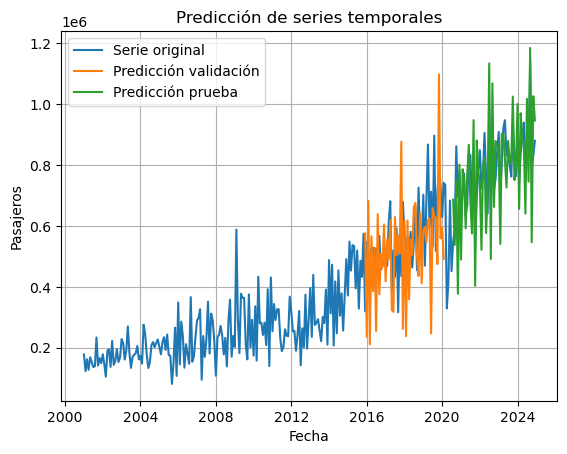

In [83]:
lags = 6  # o el valor que estés usando realmente

# Obtener solo los índices que correspondan exactamente a la cantidad de predicciones
index_val = regular_i.index[trainir_end+1+lags : trainir_end+1+lags + len(prediccion_val)]
index_test = regular_i.index[valir_end+lags : valir_end+lags + len(prediccion_test)]

df_val = pd.DataFrame(prediccion_val, index=index_val, columns=['Predicción validación'])
df_test = pd.DataFrame(prediccion_test, index=index_test, columns=['Predicción prueba'])




plt.plot(regular_i, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

In [84]:
# Valores reales y predichos
y_true = regular_i[valir_end:].iloc[:len(prediccion_test)]
y_pred = prediccion_test  # o df_test.values.flatten()

# Calcular MSE y RMSE
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Calcular promedio correctamente, ya sea Serie o DataFrame
if isinstance(y_true, pd.DataFrame):
    promedio = y_true.iloc[:, 0].mean()  # toma la primera columna
else:
    promedio = y_true.mean()

# Calcular error relativo
error_relativo = (rmse / promedio) * 100

# Mostrar resultados
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Error relativo: {error_relativo:.2f}%")

MSE: 30192433186.99
RMSE: 173759.70
Error relativo: 22.99%


#### Predicción 2025

Input shape: (1, 6, 1)
Input dtype: float32


c:\Users\dfsf2\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\dfsf2\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\dfsf2\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\dfsf2\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\dfsf2\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


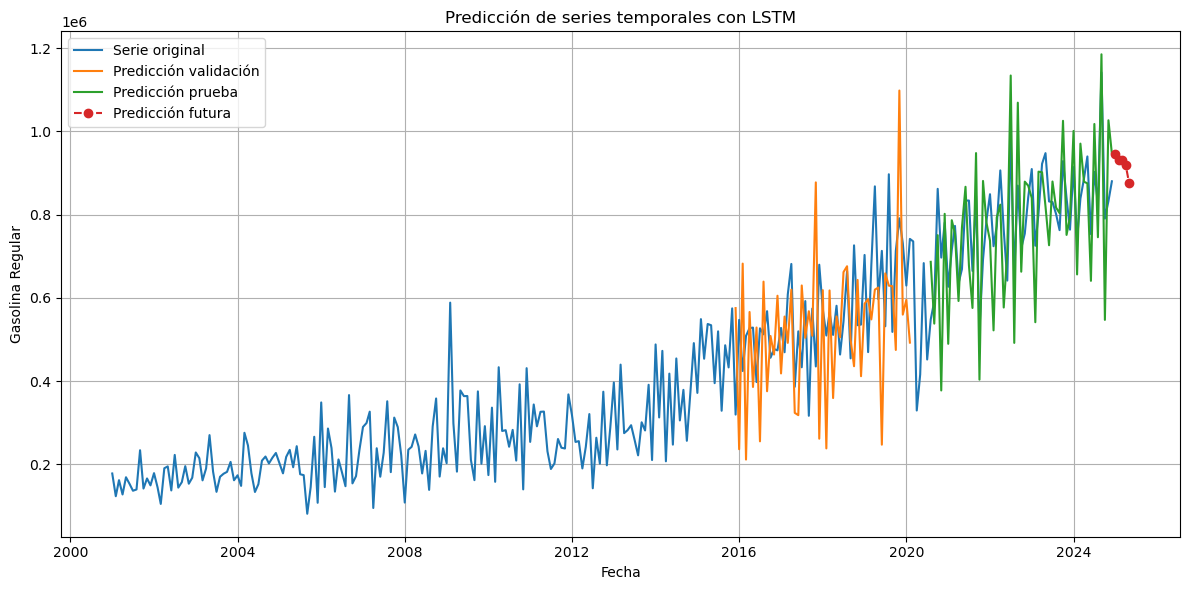

               Predicción
2025-01-01  946490.505938
2025-02-01  931312.776445
2025-03-01  931453.714785
2025-04-01  918707.766542
2025-05-01  874919.114199


In [85]:
futuro_meses = 5

ultimo_input = x_test[-1:].copy().reshape(1, 6, 1).astype(np.float32)


predicciones_futuras = []
series_aux = list(regular_i.values.flatten())

print("Input shape:", ultimo_input.shape)
print("Input dtype:", ultimo_input.dtype)


yhat_scaled = modelo2ir.predict(ultimo_input, verbose=0)

for i in range(futuro_meses):
    yhat_scaled = modelo2ir.predict(ultimo_input, batch_size=1, verbose=0)
    yhat = scaler.inverse_transform(yhat_scaled)  
    
    yhat_val = yhat[0, 0] + series_aux[-1]  
    predicciones_futuras.append(yhat_val)
    series_aux.append(yhat_val)

    nueva_diff = yhat_val - series_aux[-2]
    nuevo_valor_scaled = scaler.transform([[nueva_diff]])[0, 0]

    
    nuevo_valor_scaled = np.array([[[nuevo_valor_scaled]]], dtype=np.float32)
    ultimo_input = np.concatenate([ultimo_input[:, 1:, :], nuevo_valor_scaled], axis=1)

fechas_futuras = pd.date_range(start=regular_i.index[-1] + pd.offsets.MonthBegin(),
                               periods=futuro_meses, freq='MS')
df_future = pd.DataFrame(predicciones_futuras, index=fechas_futuras, columns=['Predicción'])

plt.figure(figsize=(12, 6))

plt.plot(regular_i, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')
plt.plot(df_future, label='Predicción futura', linestyle='--', marker='o')

plt.legend()
plt.title('Predicción de series temporales con LSTM')
plt.xlabel('Fecha')
plt.ylabel('Gasolina Regular')
plt.grid(True)
plt.tight_layout()
plt.show()

print(df_future)



### **Modelo multivariable consumo**
##### **Gasolina Regular y Gasolina Superior**

Epoch 1/50
178/178 [==============================] - 2s 3ms/step - loss: 0.5554 - val_loss: 0.8371
Epoch 2/50
178/178 [==============================] - 0s 1ms/step - loss: 0.5242 - val_loss: 0.7750
Epoch 3/50
178/178 [==============================] - 0s 1ms/step - loss: 0.5004 - val_loss: 0.7223
Epoch 4/50
178/178 [==============================] - 0s 1ms/step - loss: 0.4820 - val_loss: 0.6782
Epoch 5/50
178/178 [==============================] - 0s 1ms/step - loss: 0.4690 - val_loss: 0.6448
Epoch 6/50
178/178 [==============================] - 0s 1ms/step - loss: 0.4606 - val_loss: 0.6214
Epoch 7/50
178/178 [==============================] - 0s 1ms/step - loss: 0.4553 - val_loss: 0.6056
Epoch 8/50
178/178 [==============================] - 0s 1ms/step - loss: 0.4518 - val_loss: 0.5948
Epoch 9/50
178/178 [==============================] - 0s 1ms/step - loss: 0.4493 - val_loss: 0.5874
Epoch 10/50
178/178 [==============================] - 0s 1ms/step - loss: 0.4473 - val_loss: 0.5823

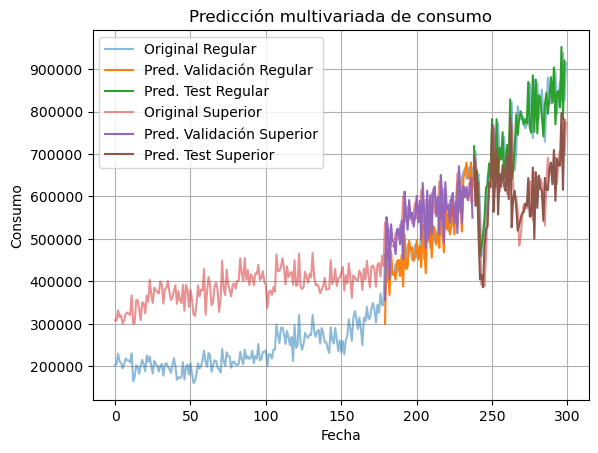

RMSE Regular: 78213.24
RMSE Superior: 82160.12
Error relativo Regular: 10.49%
Error relativo Superior: 13.35%


In [31]:

data = consumos[['Gasolina regular', 'Gasolina superior']].copy()
data_diff = data.diff().dropna()

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(data_diff)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(data_diff) 



def crear_secuencias_multivariadas(X, y, lags):
    X_out, y_out = [], []
    for i in range(len(X) - lags):
        X_out.append(X[i:i+lags, :])
        y_out.append(y[i+lags, :])
    return np.array(X_out), np.array(y_out)

lags = 1
X, y = crear_secuencias_multivariadas(X_scaled, y_scaled, lags)



train_end = int(0.6 * len(X))
val_end = train_end + int(0.2 * len(X))

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]



modelo = Sequential()
modelo.add(LSTM(10, input_shape=(lags, X.shape[2]), stateful=False))
modelo.add(Dense(2))  

modelo.compile(loss='mean_squared_error', optimizer='rmsprop')

modelo.fit(
    X_train, y_train,
    batch_size=1,
    epochs=50,
    shuffle=False,
    validation_data=(X_val, y_val),
    verbose=1
)



def prediccion_multi(data, modelo, scaler_y, batch_size, Series=None, dif=False, dif_cant=1, n=1):
    predicciones = []
    for i, X in enumerate(data):
        X = np.reshape(X, (1, X.shape[0], X.shape[1]))
        yhat = modelo.predict(X, batch_size=batch_size, verbose=0)
        yhat = scaler_y.inverse_transform(yhat)
        if dif and Series is not None:
            yhat = yhat + Series[n + dif_cant * i]
        predicciones.append(yhat[0])
    return np.array(predicciones)

original_series = data.values
pred_val = prediccion_multi(X_val, modelo, scaler_y, 1, Series=original_series, dif=True, dif_cant=1, n=train_end)
pred_test = prediccion_multi(X_test, modelo, scaler_y, 1, Series=original_series, dif=True, dif_cant=1, n=len(original_series) - len(X_test))



idx_val = data.index[train_end+1:train_end+1+len(pred_val)]
idx_test = data.index[val_end+1:val_end+1+len(pred_test)]

df_val = pd.DataFrame(pred_val, columns=['Gasolina regular', 'Gasolina superior'], index=idx_val)
df_test = pd.DataFrame(pred_test, columns=['Gasolina regular', 'Gasolina superior'], index=idx_test)

plt.plot(data['Gasolina regular'], label='Original Regular', alpha=0.5)
plt.plot(df_val['Gasolina regular'], label='Pred. Validación Regular')
plt.plot(df_test['Gasolina regular'], label='Pred. Test Regular')
plt.plot(data['Gasolina superior'], label='Original Superior', alpha=0.5)
plt.plot(df_val['Gasolina superior'], label='Pred. Validación Superior')
plt.plot(df_test['Gasolina superior'], label='Pred. Test Superior')
plt.legend()
plt.title('Predicción multivariada de consumo')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.grid(True)
plt.show()


y_true_test = data.iloc[val_end+1:val_end+1+len(pred_test)]
rmse_reg = np.sqrt(mean_squared_error(y_true_test['Gasolina regular'], df_test['Gasolina regular']))
rmse_sup = np.sqrt(mean_squared_error(y_true_test['Gasolina superior'], df_test['Gasolina superior']))

print(f"RMSE Regular: {rmse_reg:.2f}")
print(f"RMSE Superior: {rmse_sup:.2f}")

prom_reg = y_true_test['Gasolina regular'].mean()
prom_sup = y_true_test['Gasolina superior'].mean()

error_rel_reg = (rmse_reg / prom_reg) * 100
error_rel_sup = (rmse_sup / prom_sup) * 100

print(f"Error relativo Regular: {error_rel_reg:.2f}%")
print(f"Error relativo Superior: {error_rel_sup:.2f}%")
